## Setup

In [ ]:
# pip uninstall dea_tools --yes

In [ ]:
# pip install datacube==1.8.3

In [ ]:
# pip install Shapely==1.8rc1

In [1]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup

import sys
sys.path.insert(1, '../../Tools/')
from dea_tools.datahandling import mostcommon_crs
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
config = {'db_hostname': 'deadev.nci.org.au',
          'db_port': 6432,
          'db_database': 's2_test'}
dc_s2 = datacube.Datacube(app='Intertidal_elevation', config=config)
dc = datacube.Datacube(app='Intertidal_elevation')

Client Scheduler: tcp://127.0.0.1:45543 Dashboard: /proxy/8787/status,Cluster Workers: 1 Cores: 16 Memory: 47.42 GB


### Study area

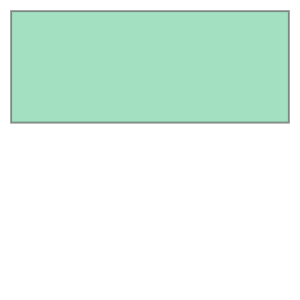

In [3]:
# aoi = 'Wollogorang'
# # aoi = 'McCarthur River'
aoi = 'Greenbank'
# # aoi = 'Seven Emu'
time_range = ('2017', '2021')
resolution = 10

# # Import regions of interest
aoi_gdf = gpd.read_file('data/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# # Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom = geom.envelope
geom

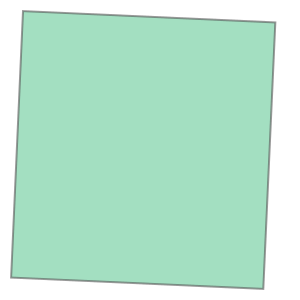

In [3]:
# xmin, ymax = 136.69496195483225, -15.818692484010818
# xmax, ymin = 136.73092570526103, -15.862001767243331

# xmin, ymax = 137.74440730133688, -16.250688880149955

# xmin, ymax = 137.70283024335083, -16.21825433795211
# xmax, ymin = 137.76211426864734, -16.279337121561642

# xmin, ymax = 139.45882983, -16.55481577
# xmax, ymin = 139.51088896, -16.59992236

# Collection 3 test 1
ymax, xmin = -15.88, 136.75
ymin, xmax = -15.92, 136.885

# Collection 3 test 2
xmin, ymax = 137.70283024335083, -16.21825433795211
xmax, ymin = 137.76211426864734, -16.279337121561642

from shapely.geometry import box
geom = Geometry(geom=box(xmin, ymin, xmax, ymax),
                crs='EPSG:4326').to_crs('EPSG:3577')
geom


### Load data

In [4]:
# Create the 'query' dictionary object
query_params = {
    'geopolygon': geom,
    'time': time_range,
    'gqa_iterative_mean_xy': [0, 1]}
    
load_params = {
    'group_by': 'solar_day',
    'resampling': {'*': 'average', 'fmask': 'nearest'},
    'dask_chunks': {'time': 1, 'x': 2048, 'y': 2048}
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc_s2, product='ga_s2am_ard_3', 
                            query=query_params)

### Combined LS and S2

In [5]:
# Load Sentinel-2 data
s2_ds = dc_s2.load(product=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
                measurements=['nbart_green', 'nbart_nir_1', 's2cloudless_mask'],
                output_crs=output_crs,
                resolution=(-resolution, resolution),
                **query_params,
                **load_params).rename({'nbart_nir_1': 'nbart_nir'})

# Apply cloud masking
s2_ds = s2_ds.where(s2_ds.s2cloudless_mask == 1)

# Apply nodata masking
s2_ds = mask_invalid_data(s2_ds)
s2_ds

,Array,Chunk
Bytes,75.49 GB,33.55 MB
Shape,"(296, 3706, 8602)","(1, 2048, 2048)"
Count,21293 Tasks,2960 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,75.49 GB,33.55 MB
Shape,"(296, 3706, 8602)","(1, 2048, 2048)"
Count,21293 Tasks,2960 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [6]:
# Load Landsat-8 data
ls_ds = dc.load(product=['ga_ls8c_ard_3'],
                measurements=['nbart_green', 'nbart_nir', 'fmask'],
                like=s2_ds.geobox,
                **{a:b for a, b in query_params.items() if a not in 'geopolygon'},
                **load_params)   

# Apply cloud masking
ls_ds = ls_ds.where(ls_ds.fmask.isin([1, 4, 5]))

# Apply nodata masking
ls_ds = mask_invalid_data(ls_ds)
ls_ds

,Array,Chunk
Bytes,54.07 GB,33.55 MB
Shape,"(212, 3706, 8602)","(1, 2048, 2048)"
Count,19301 Tasks,2120 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,54.07 GB,33.55 MB
Shape,"(212, 3706, 8602)","(1, 2048, 2048)"
Count,19301 Tasks,2120 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [8]:
# Combine into a single ds
ds = xr.concat([s2_ds.drop('s2cloudless_mask'), 
                ls_ds.drop('fmask')], dim='time').sortby('time')


## Intertidal elevation

In [9]:
# Calculate the water index
calculate_indices(ds,
                  index='NDWI',
                  collection='ga_ls_3', 
                  drop=True,
                  inplace=True)


Dropping bands ['nbart_green', 'nbart_nir']


,Array,Chunk
Bytes,129.56 GB,33.55 MB
Shape,"(508, 3706, 8602)","(1, 2048, 2048)"
Count,111722 Tasks,5080 Chunks
Type,float64,numpy.ndarray


In [10]:
# Calculate tides for each timestep in the satellite dataset
tidal_tag(ds=ds, tidepost_lat=None, tidepost_lon=None)

Setting tide modelling location from dataset centroid: 136.87, -15.94


,Array,Chunk
Bytes,129.56 GB,33.55 MB
Shape,"(508, 3706, 8602)","(1, 2048, 2048)"
Count,111722 Tasks,5080 Chunks
Type,float64,numpy.ndarray


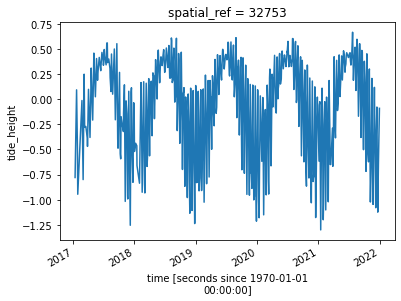

In [11]:
# Plot the resulting tide heights for each Landsat image:
ds.tide_height.plot()

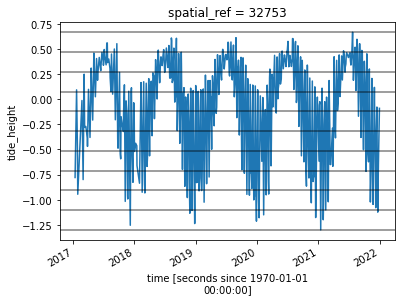

In [12]:
# classes
n = 10

# Sort every image by tide height
ds_clear = ds.sortby('tide_height')

# Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
binInterval = np.linspace(ds.tide_height.min(),
                          ds.tide_height.max(),
                          num=n+1)
tide_intervals = pd.cut(ds.tide_height,
                        bins=binInterval,
                        labels=range(1, n+1),
                        include_lowest=True)

# Add interval to dataset
ds['tide_interval'] = xr.DataArray(tide_intervals, coords=[ds.time])
ds.sortby('time').tide_height.plot()
for i in binInterval: plt.axhline(i, c='black', alpha=0.5)

In [13]:
# For each interval, compute the median water index and tide height value
landsat_intervals = (ds[['tide_interval', 'NDWI', 'tide_height']]
                     .groupby('tide_interval')
                     .median(dim='time')
                     .compute())

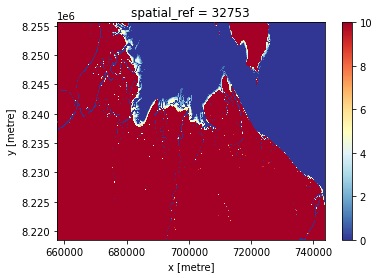

In [14]:
# Plot the resulting set of tidal intervals
item = ((landsat_intervals.NDWI < 0) * landsat_intervals.tide_interval).max(dim='tide_interval')
item.plot.imshow(cmap='RdYlBu_r')

In [15]:
# # Plot the resulting set of tidal intervals
# item2 = n - ((landsat_intervals.NDWI > 0) * ((n + 1) - landsat_intervals.tide_interval)).max(dim='tide_interval')
# item2.plot.imshow(cmap='RdYlBu_r')

In [16]:
# item = (item1 + item2) / 2.0

In [15]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=item,
                                 z_values=[i - 0.5 for i in range(1, n + 1)],
                                 crs=ds.crs,
                                 affine=ds.geobox.transform,
                                 attribute_df=attribute_df,
                                 min_vertices=2,  #20,
                                 output_path='tide_intervals.geojson',
                                 dim='tide_interval')
# contours_gdf.explore(column='tide_m')

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/geopandas/_vectorized.py:142: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  aout[:] = out
/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/geopandas/_vectorized.py:434: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  data[:] = out
/g/data/v10/public/mo

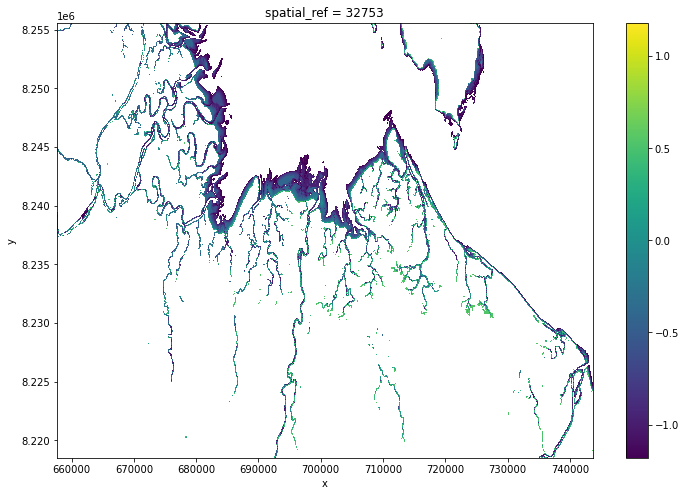

In [16]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_m')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=landsat_intervals,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2])

# Identify areas that are always wet (e.g. below low tide), or always dry
# above_lowest = landsat_intervals.isel(tide_interval=0).NDWI < 0
# below_highest = landsat_intervals.isel(tide_interval=-1).NDWI > 0

# above_lowest = mask_cleanup(above_lowest, mask_filters=[('dilation', 1)])

above_lowest = item > item.min()
below_highest = item < item.max()

# Keep only pixels between high and low tide
intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

# Plot the cleaned dataset
intertidal_dem_clean.plot(cmap='viridis', size=8)
plt.show()

In [17]:
sensor = 's2ls_gca'
# aoi = '2'
f'intertidal_dem_{sensor}_{aoi}.tif'

'intertidal_dem_s2ls_gca_Greenbank.tif'

In [18]:
# Export as a GeoTIFF
write_cog(geo_im=intertidal_dem_clean, 
          fname=f'intertidal_dem_{sensor}_{aoi}.tif', 
          overwrite=True)

PosixPath('intertidal_dem_s2ls_gca_Greenbank.tif')

In [ ]:

def eval_metrics(x, y, round=2, all_regress=False):
    """
    Calculate a set of common statistical metrics 
    based on two input actual and predicted vectors.
    
    These include:
        - Pearson correlation
        - Root Mean Squared Error
        - Mean Absolute Error
        - R-squared
        - Linear regression parameters (slope, 
          p-value, intercept, standard error)
    
    Parameters
    ----------
    x : numpy.array
        An array providing "actual" variable values
    y : numpy.array
        An array providing "predicted" variable values 
    round : int
        Number of decimal places to round each metric
        to. Defaults to 2
    all_regress : bool
        Whether to return linear regression p-value, 
        intercept and standard error (in addition to
        only regression slope). Defaults to False
        
    Returns
    -------
    A pandas.Series containing calculated metrics   
    """

    import pandas as pd
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    from math import sqrt
    from scipy import stats
    
    # Create dataframe to drop na
    xy_df = pd.DataFrame({'x': x, 'y': y}).dropna()

    # Compute linear regression
    lin_reg = stats.linregress(x=xy_df.x, y=xy_df.y)

    # Calculate statistics
    stats_dict = {
        'Correlation': xy_df.corr().iloc[0, 1],
        'RMSE': sqrt(mean_squared_error(xy_df.x, xy_df.y)),
        'MAE': mean_absolute_error(xy_df.x, xy_df.y),
        'R-squared': r2_score(xy_df.x, xy_df.y),
        'Mean difference': (xy_df.x - xy_df.y).mean(),
        'Regression slope': lin_reg.slope,
    }

    # Additional regression params
    if all_regress:
        stats_dict.update({
            'Regression p-value': lin_reg.pvalue,
            'Regression intercept': lin_reg.intercept,
            'Regression standard error': lin_reg.stderr
        })

    # Return as 
    return pd.Series(stats_dict).round(round)

ls = xr.open_rasterio(f'intertidal_dem_ls_{aoi}.tif').drop('band')
s2c1 = xr.open_rasterio(f'intertidal_dem_s2c1_{aoi}.tif').drop('band')
s2c3 = xr.open_rasterio(f'intertidal_dem_s2c3_{aoi}.tif').drop('band')

In [ ]:
from datacube.testutils.io import rio_slurp_xarray
nidem = rio_slurp_xarray(
    '/g/data/r78/rt1527/nidem/output_data/mosaics/NIDEM_unfiltered_mosaic.tif',
    ls.geobox,
    resampling="bilinear")
nidem = mask_invalid_data(nidem)


In [ ]:
eval_metrics(nidem.values.flatten(), s2c3.values.flatten())

In [ ]:
eval_metrics(nidem.values.flatten(), s2c1.values.flatten())

In [ ]:
eval_metrics(ls.values.flatten(), s2c3.values.flatten())

In [ ]:
eval_metrics(ls.values.flatten(), s2c1.values.flatten())

In [ ]:
eval_metrics(s2c1.values.flatten(), s2c3.values.flatten())

## Overlapping interval experiments

In [ ]:
landsat_intervals.NDWI.isel(tide_interval=0).plot.imshow()

In [ ]:
landsat_intervals.NDWI.isel(tide_interval=1).plot.imshow()

In [ ]:
interval = 2
((landsat_intervals.NDWI.sel(tide_interval=interval) - landsat_intervals.NDWI.sel(tide_interval=(interval - 1))) ).plot.imshow(vmin=-0.2, vmax=0.2, cmap='RdBu_r')

In [ ]:
# (landsat_intervals.NDWI.isel(tide_interval=2)).plot.imshow(vmin=-0.1, vmax=0.1, cmap='RdBu')

In [ ]:
# (landsat_intervals.NDWI.isel(tide_interval=3)).plot.imshow(vmin=-0.1, vmax=0.1, cmap='RdBu')

In [ ]:
landsat_intervals_shifted = landsat_intervals.shift(tide_interval=1)

In [ ]:
((landsat_intervals.NDWI - landsat_intervals_shifted.NDWI)).plot.imshow(col='tide_interval', vmin=-0.2, vmax=0.2, cmap='RdBu_r')

In [ ]:
bad_pixels = ((landsat_intervals.NDWI - landsat_intervals_shifted.NDWI) < 0)

In [ ]:
bad_pixels.plot.imshow(col='tide_interval')

In [ ]:
landsat_intervals.NDWI.where(~bad_pixels).plot.imshow(col='tide_interval', vmin=-0.2, vmax=0.2, cmap='RdBu_r')

In [ ]:
fill = landsat_intervals.NDWI.rolling(tide_interval=3, min_periods=3, center=True).mean()   #.plot.imshow(col='tide_interval', vmin=-0.2, vmax=0.2, cmap='RdBu_r')

In [ ]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=landsat_intervals.NDWI,
                                 z_values=[0],
                                 crs=ds_clear.crs,
                                 affine=ds_clear.geobox.transform,
                                 attribute_df=attribute_df,
                                 min_vertices=2,  #20,
                                 output_path='tide_intervals.geojson',
                                 dim='tide_interval')
contours_gdf.explore(column='tide_m')

In [ ]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=landsat_intervals.NDWI.where(~bad_pixels, fill),
                                 z_values=[0],
                                 crs=ds_clear.crs,
                                 affine=ds_clear.geobox.transform,
                                 attribute_df=attribute_df,
                                 min_vertices=2,  #20,
                                 output_path='tide_intervals.geojson',
                                 dim='tide_interval')
contours_gdf.explore(column='tide_m')

In [ ]:
landsat_intervals

In [ ]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_m')

xs=xyz_array[:, 0]
ys=xyz_array[:, 1]
sampled=xyz_array[:, 2]

In [ ]:
# xs, ys = river_geom.xy
# xs, ys = xr.DataArray(xs, dims='z'), xr.DataArray(ys, dims='z')
# sampled = dem.interp(x=xs, y=ys, method='nearest').dropna(dim='z')

In [ ]:
# Sampled river coordinates
c_sampled = xyz_array[:, 0:2]  #np.vstack([sampled.coords[c].values for c in ('x', 'y')]).T

# All (x, y) coordinates of the original DEM
dem = item
c_x, c_y = [dem.coords[c].values for c in ('x', 'y')]
c_interpolate = np.dstack(np.meshgrid(c_x, c_y)).reshape(-1, 2)

# Sampled values
values = xyz_array[:, 2]  #sampled.values.ravel()

In [ ]:
from scipy.spatial import cKDTree as KDTree
tree = KDTree(c_sampled)

In [ ]:
# IWD interpolation
distances, indices = tree.query(c_interpolate, k=10, workers=-1, 
                                distance_upper_bound=100
                               )

# weights = 1 / distances
# weights = weights / weights.sum(axis=1).reshape(-1, 1)

# interpolated_values = (weights * values[indices]).sum(axis=1)
interpolated_values = np.median(values[indices], axis=1)

In [ ]:
indices

In [ ]:
c_interpolate.shape

In [ ]:
intertidal_dem = xr.DataArray(
    interpolated_values.reshape((len(c_y), len(c_x))).T, dims=('x', 'y'), coords={'x': c_x, 'y': c_y}
)

In [ ]:
intertidal_dem.plot()

In [ ]:
tree.

## Rolling experiments

In [ ]:
# ds_clear.NDWI.load()

In [ ]:
import pickle
with open('ds_clear.pickle', 'rb') as handle:
    ds_clear = pickle.load(handle)

In [ ]:
ds_clear

In [ ]:
# Swap dimensions and sort by tide height
ds_tides = ds_clear.swap_dims({'time': 'tide_height'}).sortby('tide_height')          


In [ ]:
testing = ds_tides.rolling(tide_height=33, min_periods=15, center=True).median()

In [ ]:
# Extract waterlines
contours_gdf = subpixel_contours(da=testing.NDWI,
                                 z_values=[0],
                                 crs=ds_clear.crs,
                                 affine=ds_clear.geobox.transform,
                                 min_vertices=2,  
                                 output_path='test_rolling.geojson',
                                 dim='tide_height')

In [ ]:
contours_gdf.explore(column='tide_height', cmap='viridis')

In [ ]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_height')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=ds_clear,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2],
                                method='rbf')

# Identify areas that are always wet (e.g. below low tide), or always dry
# above_lowest = landsat_intervals.isel(tide_interval=0).NDWI < 0
# below_highest = landsat_intervals.isel(tide_interval=-1).NDWI > 0

# Keep only pixels between high and low tide
# intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

In [ ]:
intertidal_dem.isel(x=slice(0, 150), y=slice(60, 130)).plot()

In [ ]:
import numpy
import scipy.interpolate

data = numpy.random.randint(0, 10, size=(10, 10))

# Create the knots (10 knots in each direction, making 100 total
xcoord = numpy.linspace(5, data.shape[0]-5, 10)
ycoord = numpy.linspace(5, data.shape[1]-5, 10)

# Create all weights, and set them to 0 when the data is NaN
weights = numpy.ones(data.shape)
weights[numpy.isnan(data)] = 1e-15  # weights must be >0

# LSQBivariateSpline needs x and y coordinates as 1-D arrays
x, y = numpy.indices(data.shape)
spline_fit = scipy.interpolate.LSQBivariateSpline(x.ravel(), y.ravel(), data.ravel(), 
                                               xcoord, ycoord, 
                                               w=weights.ravel(),
                                               bbox=[None, None, None, None], 
                                               kx=2, ky=2)

In [ ]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Regularly-spaced, coarse grid
dx, dy = 0.4, 0.4
xmax, ymax = 2, 4
x = np.arange(-xmax, xmax, dx)
y = np.arange(-ymax, ymax, dy)
X, Y = np.meshgrid(x, y)
Z = np.exp(-(2*X)**2 - (Y/2)**2)

interp_spline = RectBivariateSpline(y, x, Z)

# Regularly-spaced, fine grid
dx2, dy2 = 0.16, 0.16
x2 = np.arange(-xmax, xmax, dx2)
y2 = np.arange(-ymax, ymax, dy2)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = interp_spline(y2, x2)

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
ax[0].plot_wireframe(X, Y, Z, color='k')

ax[1].plot_wireframe(X2, Y2, Z2, color='k')
for axes in ax:
    axes.set_zlim(-0.2,1)
    axes.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
plt.imshow(Z)

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton
rng = np.random.default_rng()
xobs = 2*Halton(2, seed=rng).random(100) - 1
yobs = np.sum(xobs, axis=1)*np.exp(-6*np.sum(xobs**2, axis=1))
xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)
fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=-0.25, vmax=0.25, shading='gouraud')
p = ax.scatter(*xobs.T, c=yobs, s=50, ec='k', vmin=-0.25, vmax=0.25)
fig.colorbar(p)
plt.show()

In [ ]:
interpolate_2d

In [ ]:
shoreline_dict = {}

for n in [3, 6, 12]:

#     # classes
#     n = 3

    # Sort every image by tide height
    ds_clear = ds_clear.sortby('tide_height')

    # Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
    binInterval = np.linspace(ds_clear.tide_height.min(),
                              ds_clear.tide_height.max(),
                              num=n+1)
    tide_intervals = pd.cut(ds_clear.tide_height,
                            bins=binInterval,
                            labels=range(1, n+1),
                            include_lowest=True)

    # Add interval to dataset
    ds_clear['tide_interval'] = xr.DataArray(tide_intervals, coords=[ds_clear.time])
#     ds_clear.sortby('time').tide_height.plot()
#     for i in binInterval: plt.axhline(i, c='black', alpha=0.5)

    # For each interval, compute the median water index and tide height value
    landsat_intervals = (ds_clear[['tide_interval', 'NDWI', 'tide_height']]
                         .groupby('tide_interval')
                         .median(dim='time')
                         .compute()
                        )

    # Set up attributes to assign to each waterline
    attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

    # Extract waterlines
    contours_gdf = subpixel_contours(da=landsat_intervals.NDWI,
                                     z_values=[0],
                                     crs=ds_clear.crs,
                                     affine=ds_clear.geobox.transform,
                                     attribute_df=attribute_df,
                                     min_vertices=2,  #20,
                                     output_path='tide_intervals.geojson',
                                     dim='tide_interval')
    
    shoreline_dict[n] = contours_gdf
#     contours_gdf.explore(column='tide_m')

In [ ]:
# shoreline_dict[3].to_crs('EPSG:4326').to_file('test_3.geojson')

In [ ]:
# shoreline_dict[6].to_crs('EPSG:4326').to_file('test_6.geojson')

In [ ]:
# shoreline_dict[12].to_crs('EPSG:4326').to_file('test_12.geojson')

In [ ]:
# shoreline_dict[6].explode().reset_index().intersects(shoreline_dict[3].unary_union)

In [ ]:
# import geopandas as gpd

In [ ]:
# line = shoreline_dict[6].iloc[0].geometry

In [ ]:
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from shapely.geometry import MultiLineString

from shapely.ops import split,snap
def split_line_by_point(line, point, tolerance: float=1.0e-8):
    return split(snap(line, point, tolerance), point)

# result = split_line_by_point(line,points)


def test(line, val):
    splitter = MultiPoint([line.interpolate(i) for i in range(0, int(line.length), 100)])
#     print(len(splitter))
    out = split_line_by_point(line, splitter)

    return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')

In [ ]:
lines_6 = shoreline_dict[6]

lines_6 = pd.concat([test(i.geometry, i.tide_m) for (x, i) in lines_6.iterrows()])
# testing.to_crs('EPSG:4326').to_file('test_6_broken.geojson')

# lines_6['geometry'] = lines_6.apply(lambda line: test(line.geometry), axis=1)
# lines_6 = lines_6.explode().reset_index(drop=True)

In [ ]:
lines_6

In [ ]:
lines_6.apply(lambda line: test(line.geometry, line.tide_m), axis=1).shape

In [ ]:
out = lines_6.apply(lambda line: test(line.geometry, line.tide_m), axis=1)
len(out.iloc[[0]].explode(ignore_index=False))

In [ ]:
lines_6.to_crs('EPSG:4326').to_file('test_6_broken.geojson')

In [ ]:
lines_6.loc[~lines_6.intersects(shoreline_dict[3].unary_union)].to_crs('EPSG:4326').to_file('test_6_nointersect.geojson')

In [ ]:
lines_6.loc[~lines_6.intersects(shoreline_dict[3].unary_union)].plot(column='tide_m')